YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data loaded for AWK: 2015-04-20 to 2025-04-16
Data loaded for X: 2015-04-20 to 2025-04-16
Data loaded for 4BY.BE: 2015-04-20 to 2025-04-16
Data loaded for 1211.HK: 2015-04-20 to 2025-04-16
Data loaded for COLO-B.CO: 2015-04-20 to 2025-04-16
Data loaded for PPC: 2015-04-20 to 2025-04-16


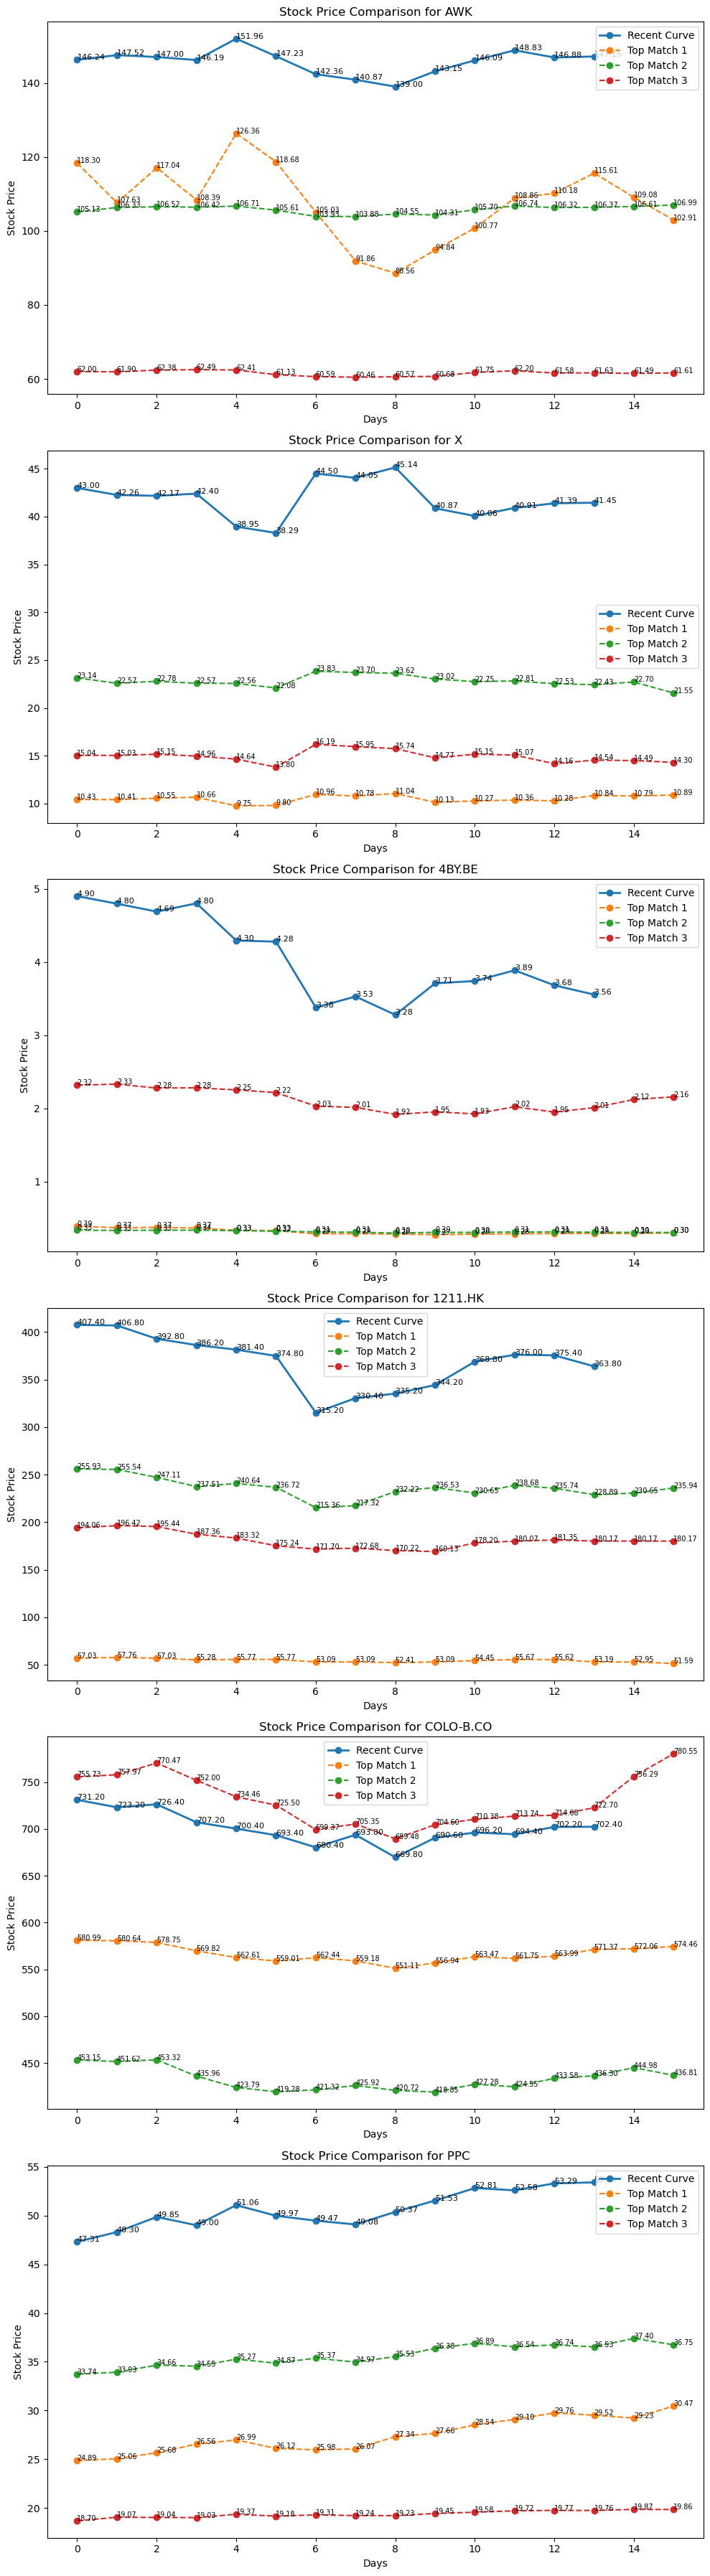


AWK - Average projected movement over next 2 days:
Day +1: 92.39
Day +2: 90.51


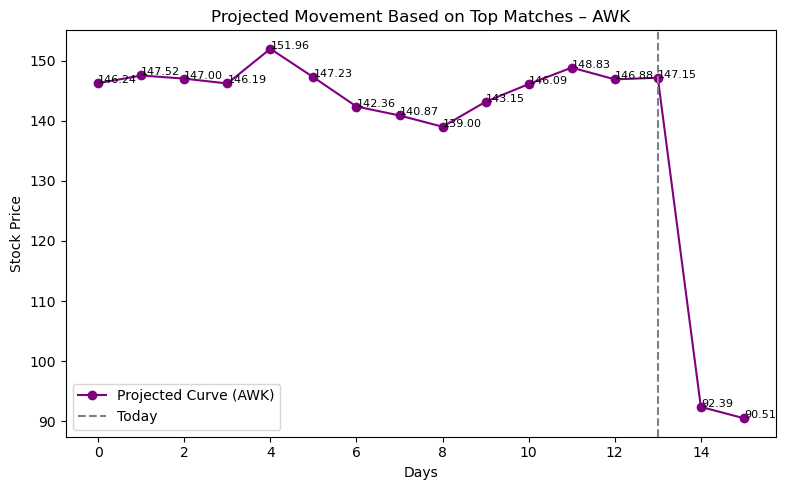


Top match indices for AWK: [1232 1048  430]
SSE values for AWK: [4.2, 4.22, 5.22]

X - Average projected movement over next 2 days:
Day +1: 15.99
Day +2: 15.58


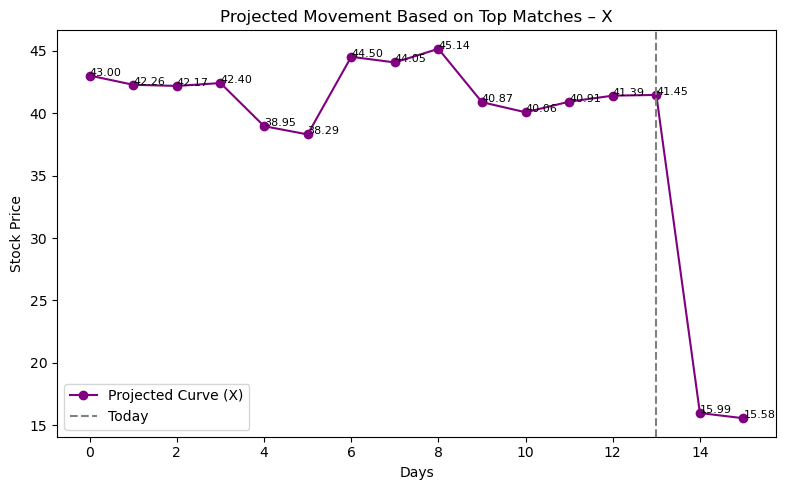


Top match indices for X: [1123   24 1011]
SSE values for X: [3.08, 4.94, 5.56]

4BY.BE - Average projected movement over next 2 days:
Day +1: 0.90
Day +2: 0.92


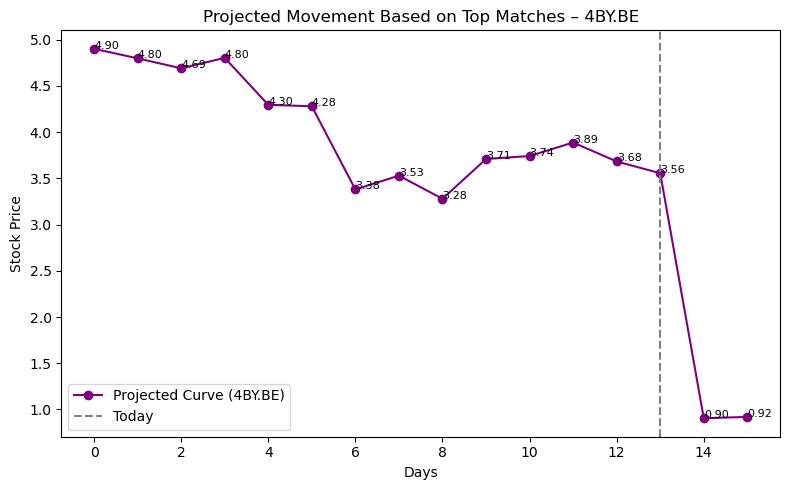


Top match indices for 4BY.BE: [  65  416 2002]
SSE values for 4BY.BE: [1.46, 1.69, 2.06]

1211.HK - Average projected movement over next 2 days:
Day +1: 154.59
Day +2: 155.90


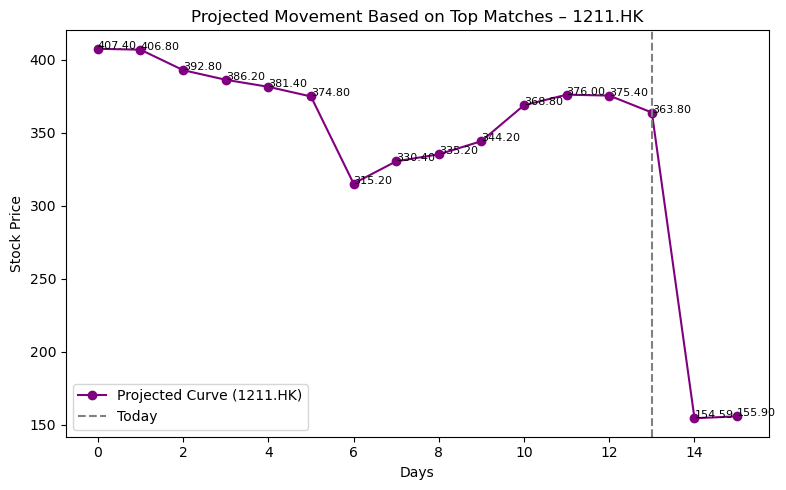


Top match indices for 1211.HK: [ 894 1670 2161]
SSE values for 1211.HK: [2.75, 3.03, 3.29]

COLO-B.CO - Average projected movement over next 2 days:
Day +1: 591.11
Day +2: 597.27


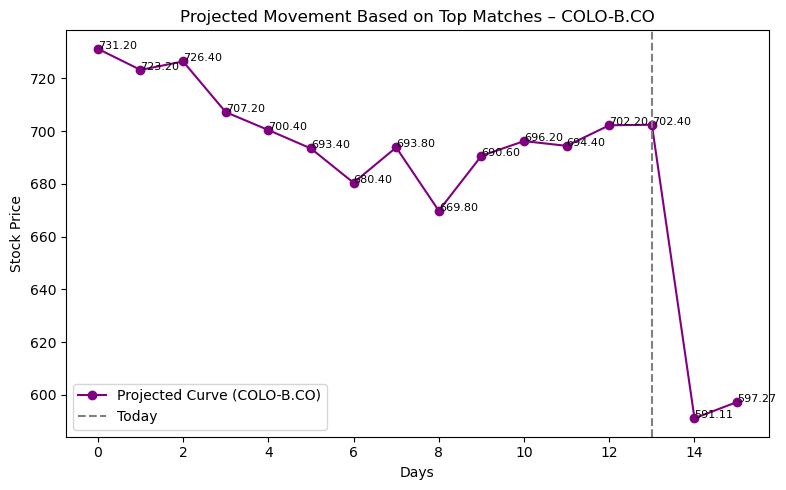


Top match indices for COLO-B.CO: [ 852  698 1779]
SSE values for COLO-B.CO: [1.97, 2.48, 2.67]

PPC - Average projected movement over next 2 days:
Day +1: 28.84
Day +2: 29.02


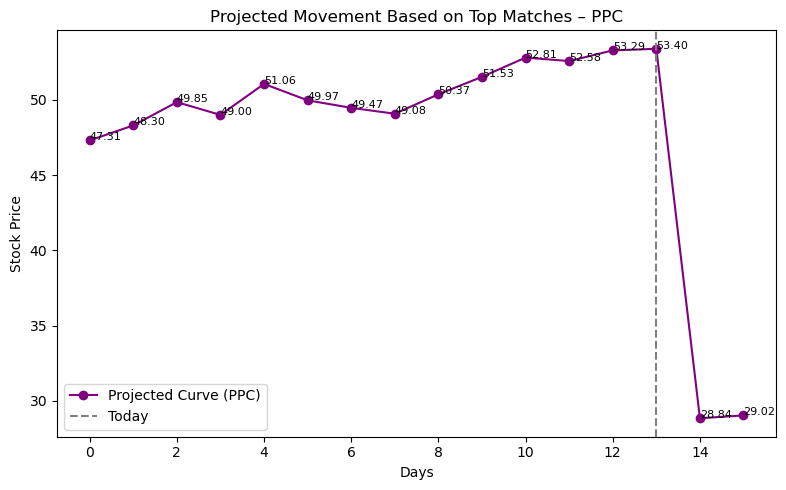


Top match indices for PPC: [1779 2323  476]
SSE values for PPC: [1.74, 1.83, 1.95]


In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

# Parameters
num_curves_to_plot = 500
days = 14
extra_days = 2
show_top = 3
years_to_pull = 10
stock_to_get = ['AWK', 'X','4BY.BE','1211.HK','COLO-B.CO','PPC']  # List of tickers to analyze

# Date range
end_date = datetime.now()
start_date = end_date - timedelta(days=years_to_pull * 365)

# Fetch historical stock data for multiple stocks
def fetch_stock_data(stock_symbols, start_date, end_date):
    stock_data = {}
    for symbol in stock_symbols:
        data = yf.download(symbol, start=start_date, end=end_date)['Close']
        stock_data[symbol] = data.dropna()
    return stock_data

# Fetch data
stock_data_dict = fetch_stock_data(stock_to_get, start_date, end_date)

# Prepare for plotting
fig, axes = plt.subplots(len(stock_to_get), figsize=(10, 6 * len(stock_to_get)))

for idx, stock in enumerate(stock_to_get):
    stock_data = stock_data_dict[stock]
    print(f"Data loaded for {stock}: {stock_data.index[0].date()} to {stock_data.index[-1].date()}")

    # Extract curves from history
    def extract_curves(data, days=7, extra_days=7):
        curves = []
        total_days = days + extra_days
        for i in range(len(data) - total_days + 1):
            curve = data[i:i+total_days].values
            curves.append(curve)
        return curves

    # Normalize a curve
    def normalize_curve(curve):
        mean = np.mean(curve)
        std = np.std(curve)
        return (curve - mean) / std

    # SSE between two curves
    def calculate_sse(curve1, curve2):
        return np.sum((curve1 - curve2[:len(curve1)]) ** 2)

    # Prepare the most recent curve
    last_x_plus_y_days_curve = stock_data[-(days):].values
    normalized_last_curve = normalize_curve(last_x_plus_y_days_curve)

    # Extract and normalize historical curves
    past_curves = extract_curves(stock_data, days=days, extra_days=extra_days)
    normalized_past_curves = [normalize_curve(curve) for curve in past_curves]

    # Find top matching curves
    sse_values = [calculate_sse(normalized_last_curve, curve) for curve in normalized_past_curves]
    sorted_indices = np.argsort(sse_values)
    closest_match_indices = sorted_indices[:num_curves_to_plot]
    top_match_indices = closest_match_indices[:show_top]
    top_curves = [past_curves[i] for i in top_match_indices]

    # --- Plot 1: Historical pattern matches ---
    ax = axes[idx]  # Select the appropriate subplot for each stock
    ax.plot(range(days), last_x_plus_y_days_curve[:days], label='Recent Curve', linewidth=2, marker='o')
    for j in range(days):
        val = last_x_plus_y_days_curve[j].item()
        ax.text(j, val, f"{val:.2f}", fontsize=8)

    for i, curve in enumerate(top_curves):
        ax.plot(range(days + extra_days), curve, label=f'Top Match {i+1}', linestyle='--', marker='o')
        for j in range(days + extra_days):
            val = curve[j].item()
            ax.text(j, val, f"{val:.2f}", fontsize=7)

    ax.set_xlabel('Days')
    ax.set_ylabel('Stock Price')
    ax.set_title(f'Stock Price Comparison for {stock}')
    ax.legend()

# Adjust layout for multiple subplots
plt.tight_layout()
plt.show()

# Forecasting and Projecting Future Movement for Multiple Stocks
for idx, stock in enumerate(stock_to_get):
    stock_data = stock_data_dict[stock]
    
    # Prepare the most recent curve
    last_x_plus_y_days_curve = stock_data[-(days):].values
    normalized_last_curve = normalize_curve(last_x_plus_y_days_curve)

    # Extract and normalize historical curves
    past_curves = extract_curves(stock_data, days=days, extra_days=extra_days)
    normalized_past_curves = [normalize_curve(curve) for curve in past_curves]

    # Find top matching curves
    sse_values = [calculate_sse(normalized_last_curve, curve) for curve in normalized_past_curves]
    sorted_indices = np.argsort(sse_values)
    closest_match_indices = sorted_indices[:num_curves_to_plot]
    top_match_indices = closest_match_indices[:show_top]
    top_curves = [past_curves[i] for i in top_match_indices]

    # --- Forecasting: Average future movement ---
    future_projections = [curve[days:days + extra_days] for curve in top_curves]
    avg_future = np.mean(future_projections, axis=0)

    print(f"\n{stock} - Average projected movement over next {extra_days} days:")
    for i, val in enumerate(avg_future):
        print(f"Day +{i+1}: {val.item():.2f}")

    # --- Plot 2: Projected future path ---
    plt.figure(figsize=(8, 5))
    recent_with_projection = np.concatenate((last_x_plus_y_days_curve[:days], avg_future))
    plt.plot(range(days + extra_days), recent_with_projection, label=f'Projected Curve ({stock})', marker='o', color='purple')

    # Annotate values
    for j in range(days + extra_days):
        val = recent_with_projection[j].item()
        plt.text(j, val, f"{val:.2f}", fontsize=8)

    # Add vertical line for "today"
    plt.axvline(days - 1, color='gray', linestyle='--', label='Today')

    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.title(f'Projected Movement Based on Top Matches – {stock}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print match details
    print(f"\nTop match indices for {stock}: {top_match_indices}")
    print(f"SSE values for {stock}: {[round(sse_values[i], 2) for i in top_match_indices]}")
